# Script to compress existing models

In [1]:
import onnx
from onnx_tf.backend import prepare

import torchvision
from torchvision import transforms
import torch
import os
import numpy as np
import tensorflow as tf
import csv
import json
from PIL import Image
import PIL
import onnx
from typing import Literal
from typing_extensions import Literal
import matplotlib.pyplot as plt
import timm

2023-12-18 13:26:13.269444: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 13:26:13.272069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 13:26:13.326193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 13:26:13.327512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 13:26:14.533827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# set up the files you are interested in
image_file='/bask/homes/f/fspo1218/amber/data/gbif_download_standalone/gbif_images/Noctuidae/Spodoptera/Spodoptera exigua/1211977745.jpg'

# Label info for the species names for the uk macro moths
f = open("/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_numeric_labels.json")
label_info = json.load(f)
label_info = label_info['species_list']
species_list_mila = list(label_info)
print(len(species_list_mila), " species in total")

num_classes = len(species_list_mila)

PATH = "/bask/homes/f/fspo1218/amber/projects/on_device_classifier/outputs/turing-costarica_v02_resnet50_2023-12-15-10-51.pt"
device = torch.device('cpu')

output_dir = '/bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica/'
os.makedirs(output_dir, exist_ok=True)

5952  species in total


In [3]:
def pytorch_to_tflite(model, output_dir, image, output_model_prefix="model"):
    
    # convert the model to onnx
    print("Converting to onnx")
    
    onnx_path = output_dir + "/" + output_model_prefix + ".onnx"
    torch.onnx.export(
            model=model.eval(),
            args=image.unsqueeze(0),
            f=onnx_path,
            verbose=False,
            export_params=True,
            do_constant_folding=False,
            input_names=['input'],
            opset_version=12,
            output_names=['output']
    )
    
    # Convert to tf
    print("Converting to tensorflow...")
    tf_path = output_dir + "/tf_" + output_model_prefix  
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    tf_rep = prepare(onnx_model, device='CPU')
    tf_rep.export_graph(tf_path)
    
    # Convert to tfLite
    print("Converting to tensorflowlite")
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
    converter.experimental_new_converter = True
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.allow_custom_ops=True
    tflite_model = converter.convert()
    
    print("Saving converted model")
    with open(output_dir + "/" + output_model_prefix + ".tflite", 'wb') as f:
        f.write(tflite_model)
        
    return tflite_model

## MILA species classifier

In [4]:
image = Image.open(image_file)

# Transform
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((300, 300)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
img = transform(image)


In [5]:
import torch, torchvision

import sys
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/models/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/data2/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/evaluation/')

from data2 import dataloader
import evaluation

In [6]:
if 'efficientnet' in PATH:
    model_py_mila = models.efficientnet_b0(pretrained=True)
    model_py_mila = model_py_mila.to(device)
    checkpoint = torch.load(PATH, map_location=device)
    model_py_mila.eval()
    
elif 'resnet' in PATH:
    model_py_mila = torchvision.models.resnet50(weights=None)
    num_ftrs = model_py_mila.fc.in_features
    model_py_mila.fc = torch.nn.Linear(num_ftrs, num_classes)
    model_py_mila = model_py_mila.to(device)
    model_py_mila = torch.load(PATH, map_location=device)
    #state_dict = checkpoint #checkpoint.get("model_state_dict") or 
    #model_py_mila.load_state_dict(state_dict)
    model_py_mila.eval()
    
    # model_py_mila = torchvision.models.resnet50(weights=None)
    # num_ftrs = model_py_mila.fc.in_features
    # model_py_mila.fc = torch.nn.Linear(num_ftrs, num_classes)
    # model_py_mila = model_py_mila.to(device)
    # checkpoint = torch.load(PATH, map_location=device)
    # state_dict = checkpoint#.get("model_state_dict") or checkpoint
    # model_py_mila.load_state_dict(state_dict)
    # # print(model.state_dict())
    # model_py_mila.eval()
    
else:
    print('clarify model type')

print("loaded MILA model")

loaded MILA model


In [7]:
tflite_model = pytorch_to_tflite(model_py_mila, 
                  output_dir=output_dir,
                  image=img, 
                  output_model_prefix="resnet_costarica")

Converting to onnx
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Converting to tensorflow...


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to onnx_tf_prefix__classifier_transpose_x, add_52_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/assets


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/assets
INFO:absl:Writing fingerprint to /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/fingerprint.pb


Converting to tensorflowlite


2023-12-18 13:26:42.873134: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-18 13:26:42.873167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-18 13:26:42.873871: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica
2023-12-18 13:26:42.908177: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-12-18 13:26:42.908200: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica
2023-12-18 13:26:43.013426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-18 13:26:43.015640: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-1

Saving converted model


In [8]:
# # Label info for the species names for the uk macro moths
# f = open("/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_numeric_labels.json")
# label_info = json.load(f)
# species_list_turing = list(label_info)
# print(len(species_list_turing), " species in total")

# num_classes = len(species_list_turing)
# PATH = "/bask/homes/f/fspo1218/amber/projects/on_device_classifier/outputs/turing-macro_v01_efficientnetv2-b3_2023-10-20-13-55.pt"
# device = torch.device('cpu')

# model_py_turing = torchvision.models.efficientnet_v2_s(weights=None)
# #num_ftrs = model_py_turing.fc.in_features
# #model_py_turing.fc = torch.nn.Linear(num_ftrs, num_classes)
# model_py_turing = model_py_turing.to(device)
# model_py_turing = torch.load(PATH, map_location=device)
# #state_dict = checkpoint.get("model_state_dict") or checkpoint
# #model_py_turing.load_state_dict(state_dict)
# model_py_turing.eval()

# print("loaded Turing Efficientnet model")

# pytorch_to_tflite(model_py_turing, "/bask/homes/f/fspo1218/amber/projects/compress_existing_models/compressed_models/turing_species_classifier", 
#                   image=img, output_model_prefix="turing_uk_denmark")

In [9]:
os.path.getsize(PATH) / 1e6

143.147498

### Test the inference time

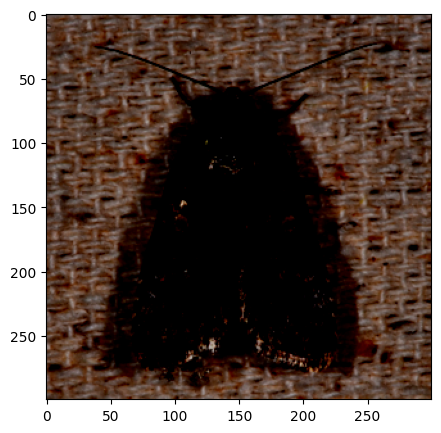

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(img.permute(1, 2, 0))

In [11]:
import datetime

def pytorch_inference(image, test_model, print_time=False):
    a = datetime.datetime.now()
    output = test_model(image.unsqueeze(0))
    predictions = torch.nn.functional.softmax(output, dim=1)
    predictions = predictions.detach().numpy()

    categories = predictions.argmax(axis=1)
    #print(categories)
    b = datetime.datetime.now()
    c = b - a
    if print_time: print(str(c.microseconds) + "\u03bcs")
    return(categories[0])
    
def tflite_inference(image, interpreter, print_time=False):
    a = datetime.datetime.now()
    interpreter.set_tensor(input_details[0]['index'], image.unsqueeze(0))
    interpreter.invoke()
    outputs_tf = interpreter.get_tensor(output_details[0]['index'])
    prediction_tf = np.squeeze(outputs_tf)
    prediction_tf = prediction_tf.argsort()[::-1][0]
    #print(prediction_tf)
    b = datetime.datetime.now()
    c = b - a
    if print_time: print(str(c.microseconds) + "\u03bcs")
    return(prediction_tf)
        

In [12]:
pytorch_inf = pytorch_inference(img, model_py_mila)

In [13]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=os.path.join(output_dir, 'resnet_costarica.tflite'))

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
tflite_inf = tflite_inference(img, interpreter)

In [15]:
print('TFlite says', species_list_mila[tflite_inf])
print('Pytorch says', species_list_mila[pytorch_inf])
print('Truth says', os.path.basename(os.path.dirname(image_file)))

TFlite says Oxydia geminata
Pytorch says Oxydia geminata
Truth says Spodoptera exigua


# Inference on Crops

In [ ]:
# import os
# image_paths = "/bask/homes/f/fspo1218/amber/data/binary_moth_training/gbif_crops/"
# images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_paths) for f in filenames if os.path.splitext(f)[1] == '.jpg']

In [ ]:
# images=images[0:100]
# len(images)

In [ ]:
# headers = ['tf_pred', 'pytorch_pred', 'true_species', '\n']

# out_inf_file = '/bask/projects/v/vjgo8416-amber/projects/compress_existing_models/output_file2.csv'

# with open(out_inf_file,'w', newline="") as fd:
#     fd.write(','.join(headers))

In [ ]:
# def infer_all(i):
#     image = Image.open(images[i])
#     img = transform(image)

#     tf_pred = tflite_inference(img, interpreter)
#     pytorch_pred = pytorch_inference(img, model_py_mila)

#     tf_pred = species_list_mila[int(tf_pred)]
#     pytorch_pred = species_list_mila[int(pytorch_pred)]

#     true_species = os.path.basename(os.path.dirname(images[i]))

#     #print(tf_pred, pytorch_pred, true_species)
#     line = [tf_pred, pytorch_pred, true_species, '\n']
#     line = ','.join(line)
#     with open(out_inf_file,'a') as fd:
#         fd.write(line)
#     return line

In [ ]:
# mixed = []

# for i in range(len(images)):
#     print(str(i) + "/" + str(len(images)))
#     out = infer_all(i)
#     mixed.append(out)

In [ ]:
# sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/data2/')

In [ ]:


# tf_rep = tf.lite.Interpreter(os.path.join(output_dir, 'resnet_costarica.tflite'))
# tf_rep.allocate_tensors()


# HERE!

In [17]:
config_file = '/bask/homes/f/fspo1218/amber/projects/on_device_classifier/configs/01_costarica_data_config.json'
f = open(config_file)
config_data = json.load(f)
    
taxon_hierar = config_data["dataset"]["taxon_hierarchy"]
li= config_data["dataset"]["label_info"]

In [41]:
config_data

{'note': 'This config file is for training on the complete moths dataset',
 'model': {'species_num_classes': 5952,
  'genus_num_classes': 1657,
  'family_num_classes': 64,
  'type': 'resnet50',
  'preprocess_mode': 'tf'},
 'dataset': {'label_info': '/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_numeric_labels.json',
  'taxon_hierarchy': '/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_taxon_hierarchy.json'},
 'training': {'batch_size': 64,
  'image_resize': 300,
  'epochs': 30,
  'early_stopping': 4,
  'start_val_loss': 100000000,
  'loss': {'name': 'crossentropy'},
  'optimizer': {'name': 'sgd', 'learning_rate': 0.001, 'momentum': 0.9},
  'wandb': {'entity': 'kg-test', 'project': 'gbif'},
  'model_save_path': '/bask/projects/v/vjgo8416-amber/projects/on_device_classifier/outputs/',
  'model_name': 'turing-costarica',
  'version': 'v02'}}

In [43]:
image_resize = config_data["training"]["image_resize"]
batch_size = config_data["training"]["batch_size"]
label_list = config_data["dataset"]["label_info"]
preprocess_mode = config_data["model"]["preprocess_mode"]

# Load in the test data
test_dataloader = dataloader.build_webdataset_pipeline(
        sharedurl="/bask/homes/f/fspo1218/amber/data/gbif_costarica/test/test-500-{000000..000008}.tar",
        input_size=image_resize,
        batch_size=batch_size,
        is_training=False,
        num_workers=4,
        preprocess_mode=preprocess_mode,
    )
print("images loaded")

images loaded


In [81]:
interpreter = tf.lite.Interpreter(model_path=os.path.join(output_dir, 'resnet_costarica.tflite'))

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

In [82]:
# Define your preprocess_for_tflite and postprocess_for_tflite functions accordingly
def preprocess_for_tflite(image_batch):
    # Your preprocessing logic for TensorFlow Lite input
    # Convert PyTorch tensor to NumPy array if needed
    return np.array(image_batch)

def postprocess_for_tflite(output_data):
    # Your postprocessing logic for TensorFlow Lite output
    # Convert NumPy array to PyTorch tensor if needed
    return torch.tensor(output_data)

global_microacc_data = None
global_macroacc_data = None
global_confusion_data_sp = None
global_confusion_data_g = None
global_confusion_data_f = None
preds=None
i=1
    
for image_batch, label_batch in test_dataloader:
    print(i, '/', no_iterations)
    i = i + 1
     
    # Preprocess the input image_batch for TensorFlow Lite model
    # You need to replace this preprocessing logic based on your TensorFlow Lite model requirements
    input_data = preprocess_for_tflite(image_batch)
    
    # Run inference using TensorFlow Lite model for each image in the batch
    predictions_tflite_batch = []
    for single_input_data in input_data:
        single_input_data = np.expand_dims(single_input_data, axis=0)  # Add batch dimension
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], single_input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        predictions_tflite_batch.append(output_data)

    # Stack predictions for the entire batch
    predictions_tflite_batch = np.vstack(predictions_tflite_batch)

    # Assuming `postprocess_for_tflite` is a function to postprocess the output_data
    # You need to replace this postprocessing logic based on your TensorFlow Lite model requirements
    predictions_tflite_batch = postprocess_for_tflite(predictions_tflite_batch)
    
    preds = predictions_tflite_batch#.argmax(axis=1)




1 / 94
2 / 94
3 / 94
4 / 94
5 / 94
6 / 94
7 / 94
8 / 94
9 / 94
10 / 94
11 / 94
12 / 94
13 / 94
14 / 94
15 / 94
16 / 94
17 / 94
18 / 94
19 / 94
20 / 94
21 / 94
22 / 94
23 / 94
24 / 94
25 / 94
26 / 94
27 / 94
28 / 94
29 / 94
30 / 94
31 / 94
32 / 94
33 / 94
34 / 94
35 / 94
36 / 94
37 / 94
38 / 94
39 / 94
40 / 94
41 / 94
42 / 94
43 / 94
44 / 94
45 / 94
46 / 94
47 / 94
48 / 94
49 / 94
50 / 94
51 / 94
52 / 94
53 / 94
54 / 94
55 / 94
56 / 94
57 / 94
58 / 94
59 / 94
60 / 94
61 / 94
62 / 94
63 / 94
64 / 94
65 / 94
66 / 94
67 / 94
68 / 94
69 / 94
70 / 94
71 / 94
72 / 94
73 / 94
74 / 94
75 / 94
76 / 94
77 / 94
78 / 94
79 / 94
80 / 94
81 / 94
82 / 94
83 / 94
84 / 94
85 / 94
86 / 94
87 / 94
88 / 94
89 / 94
90 / 94
91 / 94
92 / 94
93 / 94
94 / 94


In [83]:
preds

tensor([[ 0.0758,  0.2760, -0.0485,  ...,  0.7681,  0.6677, -0.0432],
        [ 0.0305,  0.5411, -0.0995,  ...,  0.6437, -0.1521, -0.0877],
        [-0.0247,  0.2612, -0.0605,  ...,  0.8674,  0.1129, -0.0796],
        ...,
        [ 0.1025,  0.2821,  0.1438,  ...,  0.1738,  0.3522,  0.0274],
        [ 0.3488,  0.0638, -0.0492,  ...,  0.2617, -0.0510,  0.0666],
        [-0.1019, -0.1429, -0.1302,  ...,  0.0889,  0.1585,  0.2871]])

In [59]:

image_dummy, label_dummy = next(iter(test_dataloader))
image_batch = image_dummy.to("cpu", non_blocking=True)
label_batch = label_dummy.to("cpu", non_blocking=True)


# Load the TFLite model and allocate tensors.
def infer_image(image):
    interpreter.set_tensor(input_details[0]['index'], image.unsqueeze(0))
    interpreter.invoke()
    outputs_tf = interpreter.get_tensor(output_details[0]['index'])
    prediction_tf = np.squeeze(outputs_tf)
    return prediction_tf
    #prediction_tf = prediction_tf.argsort()[::-1][0]
print('tflite pred:', species_list_mila[prediction_tf])



tflite pred: Euglyphis phyllis


TypeError: only integer tensors of a single element can be converted to an index

In [75]:
predictions[0]

tensor([-0.1422,  0.1361,  0.0626,  ...,  0.2899,  0.4628, -0.1215],
       grad_fn=<SelectBackward0>)

In [73]:
# Pytorch
model2 = model_py_mila
predictions = model2(image_batch)

inds = [species_list_mila[int(i)] for i in predictions.argmax(axis=1).squeeze().tolist()]
print('pytorch pred:')
inds[0:10]

pytorch pred:


['Euglyphis phyllis',
 'Collomena metaphaea',
 'Eois multilunata',
 'Epitausa atriplaga',
 'Paectes canofusa',
 'Truncaptera gigantea',
 'Cymosafia pallida',
 'Netechma pyrrhodelta',
 'Gorgone fellearis',
 'Palthis hieronymus']

In [29]:
from evaluation import micro_accuracy_batch
from evaluation import macro_accuracy_batch
from evaluation import confusion_data_conversion
from evaluation import confusion_matrix_data

In [28]:
no_iterations = sum(1 for _ in enumerate(test_dataloader))

print('There are ', no_iterations, ' iterations')

There are  94  iterations


In [85]:
py_global_microacc_data = None
py_global_macroacc_data = None
py_global_confusion_data_sp = None
py_global_confusion_data_g = None
py_global_confusion_data_f = None

tf_global_microacc_data = None
tf_global_macroacc_data = None
tf_global_confusion_data_sp = None
tf_global_confusion_data_g = None
tf_global_confusion_data_f = None
i=1

#model_py_mila.eval()
    
for image_batch, label_batch in test_dataloader:
    print(i, '/', no_iterations)
    i = i + 1
    
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    py_predictions = model_py_mila(image_batch)
    
    # Preprocess the input image_batch for TensorFlow Lite model
    # You need to replace this preprocessing logic based on your TensorFlow Lite model requirements
    input_data = preprocess_for_tflite(image_batch)
    
    # Run inference using TensorFlow Lite model for each image in the batch
    predictions_tflite_batch = []
    for single_input_data in input_data:
        single_input_data = np.expand_dims(single_input_data, axis=0)  # Add batch dimension
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], single_input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        predictions_tflite_batch.append(output_data)

    # Stack predictions for the entire batch
    predictions_tflite_batch = np.vstack(predictions_tflite_batch)

    # Assuming `postprocess_for_tflite` is a function to postprocess the output_data
    # You need to replace this postprocessing logic based on your TensorFlow Lite model requirements
    tf_predictions = postprocess_for_tflite(predictions_tflite_batch)
    
    #predictions_tf = predictions_tflite_batch#.argmax(axis=1)
    


    # Pytorch Metrics
    # micro-accuracy calculation
    py_micro_accuracy = micro_accuracy_batch.MicroAccuracyBatch(
        py_predictions, label_batch, li, taxon_hierar
    ).batch_accuracy()
    py_global_microacc_data = micro_accuracy_batch.add_batch_microacc(
        py_global_microacc_data, py_micro_accuracy
    )
    # macro-accuracy calculation
    py_macro_accuracy = macro_accuracy_batch.MacroAccuracyBatch(
        py_predictions, label_batch, li, taxon_hierar
    ).batch_accuracy()
    py_global_macroacc_data = macro_accuracy_batch.add_batch_macroacc(
        py_global_macroacc_data, py_macro_accuracy
    )

    # confusion matrix
    (
        py_sp_label_batch,
        py_sp_predictions,
        py_g_label_batch,
        py_g_predictions,
        py_f_label_batch,
        py_f_predictions,
    ) = confusion_data_conversion.ConfusionDataConvert(
        py_predictions, label_batch, li, taxon_hierar
    ).converted_data()

    py_global_confusion_data_sp = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_sp, [py_sp_label_batch, py_sp_predictions]
    )
    py_global_confusion_data_g = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_g, [py_g_label_batch, py_g_predictions]
    )
    py_global_confusion_data_f = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_f, [py_f_label_batch, py_f_predictions]
    )
    
    # TFLite Metrics
    # micro-accuracy calculation
    tf_micro_accuracy = micro_accuracy_batch.MicroAccuracyBatch(
        tf_predictions, label_batch, li, taxon_hierar
    ).batch_accuracy()
    tf_global_microacc_data = micro_accuracy_batch.add_batch_microacc(
        tf_global_microacc_data, tf_micro_accuracy
    )
    # macro-accuracy calculation
    tf_macro_accuracy = macro_accuracy_batch.MacroAccuracyBatch(
        tf_predictions, label_batch, li, taxon_hierar
    ).batch_accuracy()
    tf_global_macroacc_data = macro_accuracy_batch.add_batch_macroacc(
        tf_global_macroacc_data, tf_macro_accuracy
    )

    # confusion matrix
    (
        tf_sp_label_batch,
        tf_sp_predictions,
        tf_g_label_batch,
        tf_g_predictions,
        tf_f_label_batch,
        tf_f_predictions,
    ) = confusion_data_conversion.ConfusionDataConvert(
        tf_predictions, label_batch, li, taxon_hierar
    ).converted_data()

    tf_global_confusion_data_sp = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_sp, [tf_sp_label_batch, tf_sp_predictions]
    )
    tf_global_confusion_data_g = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_g, [tf_g_label_batch, tf_g_predictions]
    )
    tf_global_confusion_data_f = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_f, [tf_f_label_batch, tf_f_predictions]
    )

1 / 94
2 / 94
3 / 94
4 / 94
5 / 94
6 / 94
7 / 94
8 / 94
9 / 94
10 / 94
11 / 94
12 / 94
13 / 94
14 / 94
15 / 94
16 / 94
17 / 94
18 / 94
19 / 94
20 / 94
21 / 94
22 / 94
23 / 94
24 / 94
25 / 94
26 / 94
27 / 94
28 / 94
29 / 94
30 / 94
31 / 94
32 / 94
33 / 94
34 / 94
35 / 94
36 / 94
37 / 94
38 / 94
39 / 94
40 / 94
41 / 94
42 / 94
43 / 94
44 / 94
45 / 94
46 / 94
47 / 94
48 / 94
49 / 94
50 / 94
51 / 94
52 / 94
53 / 94
54 / 94
55 / 94
56 / 94
57 / 94
58 / 94
59 / 94
60 / 94
61 / 94
62 / 94
63 / 94
64 / 94
65 / 94
66 / 94
67 / 94
68 / 94
69 / 94
70 / 94
71 / 94
72 / 94
73 / 94
74 / 94
75 / 94
76 / 94
77 / 94
78 / 94
79 / 94
80 / 94
81 / 94
82 / 94
83 / 94
84 / 94
85 / 94
86 / 94
87 / 94
88 / 94
89 / 94
90 / 94
91 / 94
92 / 94
93 / 94
94 / 94


In [86]:
import pandas as pd

py_final_micro_accuracy = micro_accuracy_batch.final_microacc(py_global_microacc_data)
py_final_macro_accuracy, py_taxon_acc = macro_accuracy_batch.final_macroacc(py_global_macroacc_data)

tf_final_micro_accuracy = micro_accuracy_batch.final_microacc(tf_global_microacc_data)
tf_final_macro_accuracy, tf_taxon_acc = macro_accuracy_batch.final_macroacc(tf_global_macroacc_data)
#tax_accuracy = taxon_accuracy(taxon_acc, label_read)

print(py_final_micro_accuracy, py_final_macro_accuracy)
print(tf_final_micro_accuracy, tf_final_macro_accuracy)

# # saving evaluation data to file
# confdata_pd_f = pd.DataFrame(
#     {
#         "F_Truth": global_confusion_data_f[0].reshape(-1),
#         "F_Prediction": global_confusion_data_f[1].reshape(-1),
#     }
# )
# confdata_pd_g = pd.DataFrame(
#     {
#         "G_Truth": global_confusion_data_g[0].reshape(-1),
#         "G_Prediction": global_confusion_data_g[1].reshape(-1),
#     }
# )
# confdata_pd_sp = pd.DataFrame(
#     {
#         "S_Truth": global_confusion_data_sp[0].reshape(-1),
#         "S_Prediction": global_confusion_data_sp[1].reshape(-1),
#     }
# )
# confdata_pd = pd.concat([confdata_pd_f, confdata_pd_g, confdata_pd_sp], axis=1)
#confdata_pd.to_csv('./outputs/' + 'costarica_resnet' + "_v2.0" + "_confusion-data.csv", index=False)

{'micro_species_top1': 93.34, 'micro_species_top3': 97.53, 'micro_species_top10': 98.92, 'micro_genus_top1': 93.34, 'micro_genus_top3': 97.53, 'micro_genus_top10': 98.92, 'micro_family_top1': 94.61, 'micro_family_top3': 98.42, 'micro_family_top10': 99.55} {'macro_species_top1': 80.95, 'macro_species_top3': 88.95, 'macro_species_top10': 91.93, 'macro_genus_top1': 81.82, 'macro_genus_top3': 88.66, 'macro_genus_top10': 91.67, 'macro_family_top1': 93.93, 'macro_family_top3': 97.75, 'macro_family_top10': 99.16}
{'micro_species_top1': 93.22, 'micro_species_top3': 97.51, 'micro_species_top10': 98.94, 'micro_genus_top1': 93.24, 'micro_genus_top3': 97.51, 'micro_genus_top10': 98.94, 'micro_family_top1': 94.59, 'micro_family_top3': 98.42, 'micro_family_top10': 99.55} {'macro_species_top1': 80.55, 'macro_species_top3': 88.94, 'macro_species_top10': 91.94, 'macro_genus_top1': 81.51, 'macro_genus_top3': 88.65, 'macro_genus_top10': 91.68, 'macro_family_top1': 93.88, 'macro_family_top3': 97.69, 'macr

In [87]:
print(final_micro_accuracy)

{'micro_species_top1': 93.34, 'micro_species_top3': 97.53, 'micro_species_top10': 98.92, 'micro_genus_top1': 93.34, 'micro_genus_top3': 97.53, 'micro_genus_top10': 98.92, 'micro_family_top1': 94.61, 'micro_family_top3': 98.42, 'micro_family_top10': 99.55}


In [48]:
confdata_pd

,F_Truth,F_Prediction,G_Truth,G_Prediction,S_Truth,S_Prediction
0,24,24,797,797,3266,3266
1,56,56,211,211,3393,3393
2,57,57,1519,1519,2911,2911
3,53,53,531,531,5183,5183
4,42,42,835,835,110,110
...,...,...,...,...,...,...
5822,53,53,1103,1103,5185,5185
5823,57,57,691,691,715,715
5824,57,57,691,691,715,715
5825,53,53,1323,1323,4697,4697


In [39]:
with open(
    './outputs/' + 'costarica_resnet' + "_v2.0" + "_micro-accuracy.json", "w"
) as outfile:
    json.dump(final_micro_accuracy, outfile)

with open(
    './outputs/' + 'costarica_resnet' + "_v2.0" + "_macro-accuracy.json", "w"
) as outfile:
    json.dump(final_macro_accuracy, outfile)

# with open(
#     './outputs/' + 'costarica_resnet' + "_v2.0" + "_taxon-accuracy.json", "w"
# ) as outfile:
#     json.dump(tax_accuracy, outfile)